<a href="https://colab.research.google.com/github/Davidsanzb/TFM-David/blob/main/Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6355 - auc: 0.5528 - loss: 0.6949 - precision: 0.4618 - recall: 0.4583 - val_accuracy: 0.9011 - val_auc: 0.9224 - val_loss: 0.3777 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8916 - auc: 0.9230 - loss: 0.3568 - precision: 0.9260 - recall: 0.7673 - val_accuracy: 0.9121 - val_auc: 0.9645 - val_loss: 0.2325 - val_precision: 0.8929 - val_recall: 0.8333
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9282 - auc: 0.9768 - loss: 0.2273 - precision: 0.9955 - recall: 0.8350 - val_accuracy: 0.9231 - val_auc: 0.9776 - val_loss: 0.1734 - val_precision: 0.8966 - val_recall: 0.8667
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9638 - auc: 0.9923 - loss: 0.1396 - precision: 0.9886 - recall: 0.9091 - val_accuracy: 0.9560 - val_auc: 0.9825 - val_loss: 0.1449 - val_precision: 0.9643 - val_recall: 0.9000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━

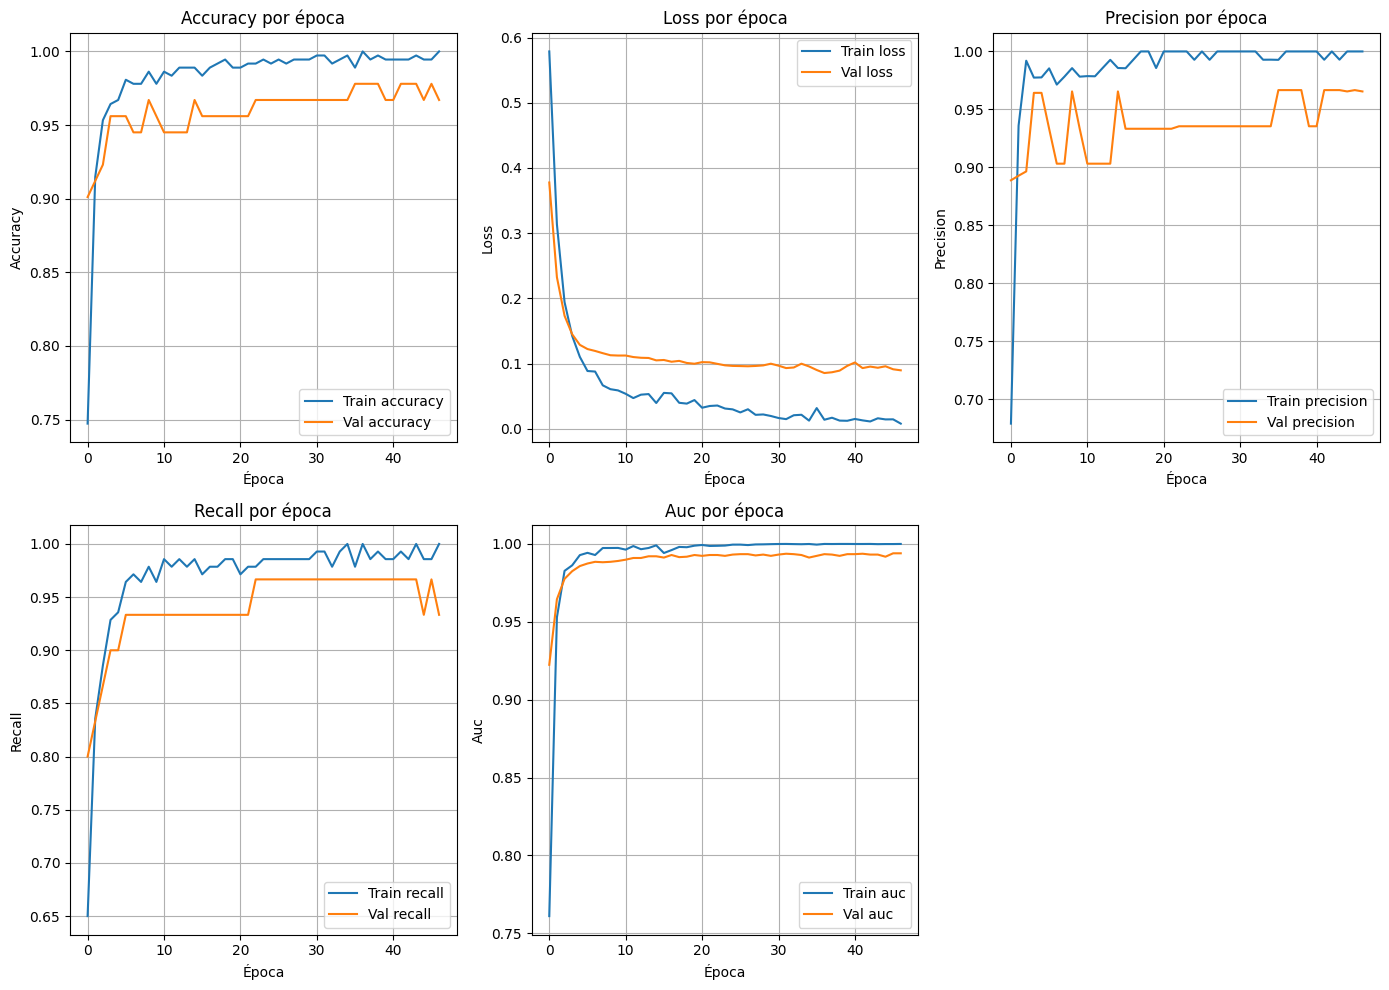

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9730    1.0000    0.9863        72
         1.0     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114



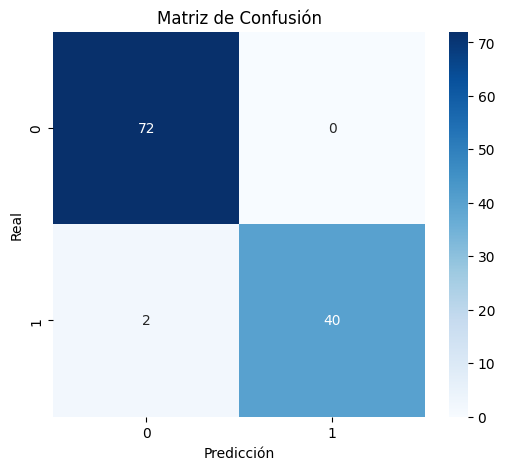

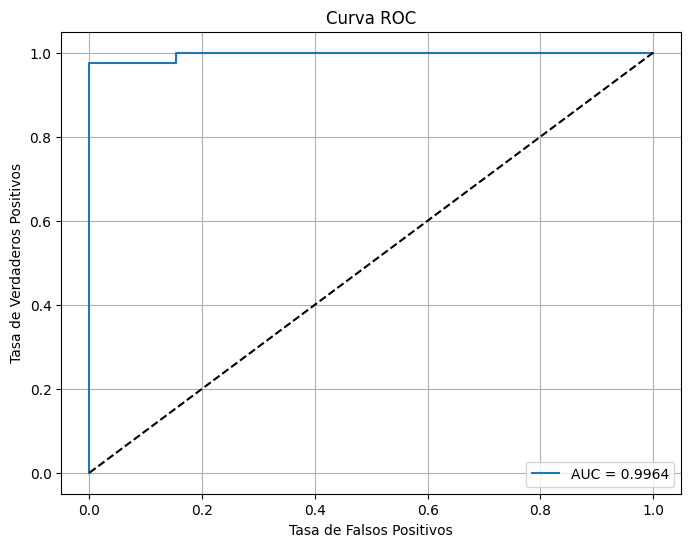

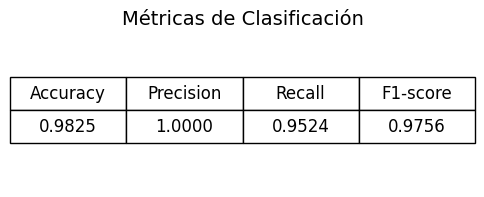

In [3]:
# ----------------------------------------
# 1. CARGA Y PREPROCESAMIENTO
# ----------------------------------------

import numpy as np
import pandas as pd

# Cargar la base de datos.
df = pd.read_csv("Breast_Cancer_Database.csv")

# Eliminar columna 'id'.
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Codificar la variable objetivo (diagnosis).
# Convierte esta variable de valores categóricos a valores numéricos.
from sklearn.preprocessing import LabelEncoder
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# Separar variables predictoras(X) y variable objetivo(y).
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Escalado (normalización) de las variables predictoras.
# Media 0 y desviación estándar 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar el conjunto de datos en entrenamiento y test.
# 80% entrenamiento y 20% test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Conversión a float32 por compatibilidad con TensorFlow.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# ----------------------------------------
# 2. RED NEURONAL DE CLASIFICACIÓN
# ----------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Definición del modelo(red neuronal secuencial).
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)), # Capa de entrada
    layers.Dense(64, activation='relu'),     # Capa oculta (64 neuronas)
    layers.Dropout(0.3),                     # Regularización para evitar el sobreajuste
    layers.Dense(32, activation='relu'),     # Capa oculta (32 neuronas)
    layers.Dense(1, activation='sigmoid')   # Capa de salida (función sigmoide)
])

# Compilación del modelo.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Función de pérdida
    metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall(),
             keras.metrics.AUC()]
)

# Entrenamiento del modelo.
# EarlyStopping va a parar el entrenamiento si no hay mejora en 10 épocas consecutivas.
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación en el conjunto de test una vez entrenado.
results = model.evaluate(X_test, y_test, verbose=0)
print("\nResultados en test:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

# ----------------------------------------
# 3. VISUALIZACIÓN DE MÉTRICAS Y GRÁFICAS
# ----------------------------------------

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Graficar métricas por época.
def plot_training_history(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(14, 10))
    for i, metric in enumerate(metrics, 1):
        if metric in history.history:
            plt.subplot(2, 3, i)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            plt.title(f'{metric.capitalize()} por época')
            plt.xlabel('Época')
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Predicciones.
# Convierte las probabilidades generadas por la red en clases predichas(0 o 1).
# Si la probabilidad es ≥ 0.5, se considera clase 1. Si es < 0.5, se considera clase 0.
y_pred_proba = model.predict(X_test).flatten()
y_pred_labels = (y_pred_proba >= 0.5).astype(int)

# Classification report.
# Precision, Recall, F1-score y Support para cada clase.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, digits=4))

# Matriz de confusión del modelo.
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC de la red neuronal de clasificación.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calcular métricas finales.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred_labels)
prec = precision_score(y_test, y_pred_labels)
rec = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Visualización de estas métricas en una tabla.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
tabla = plt.table(cellText=[[f"{acc:.4f}", f"{prec:.4f}", f"{rec:.4f}", f"{f1:.4f}"]],
                  colLabels=["Accuracy", "Precision", "Recall", "F1-score"],
                  cellLoc='center', loc='center')
tabla.scale(1, 2)
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
plt.title("Métricas de Clasificación", fontsize=14)
plt.show()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 1039882.0625 - mae: 860.1526 - mse: 1039882.0625 - val_loss: 1189555.0000 - val_mae: 883.7407 - val_mse: 1189555.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1075143.3750 - mae: 875.0731 - mse: 1075143.3750 - val_loss: 1178659.7500 - val_mae: 879.1896 - val_mse: 1178659.7500
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 933880.3750 - mae: 820.4088 - mse: 933880.3750 - val_loss: 1155634.7500 - val_mae: 870.2382 - val_mse: 1155634.7500
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1057008.6250 - mae: 874.2241 - mse: 1057008.6250 - val_loss: 1112505.8750 - val_mae: 854.1103 - val_mse: 1112505.8750
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 977430.6875 - mae: 831.4219 - mse: 977430.6875 - val_loss: 1040508.3750 - val_mae: 826.8381 - val_mse: 1040508.3750
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1051212.7500 - mae: 852.8659 - mse: 1051212.7500 - val_loss

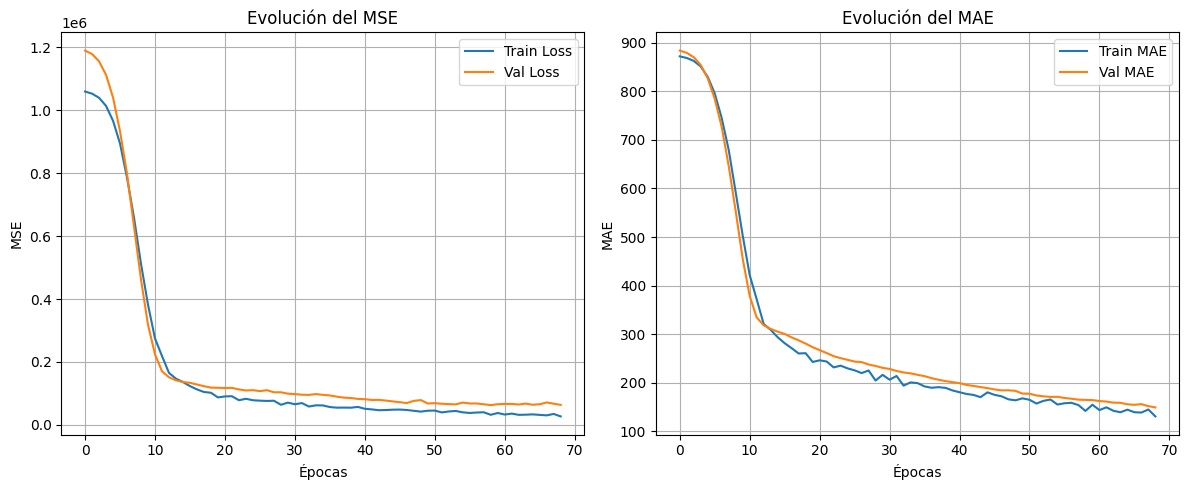

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


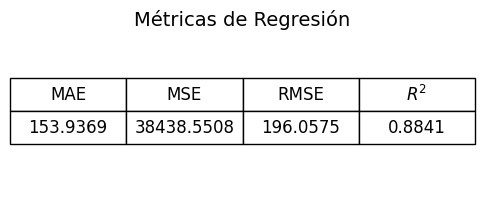

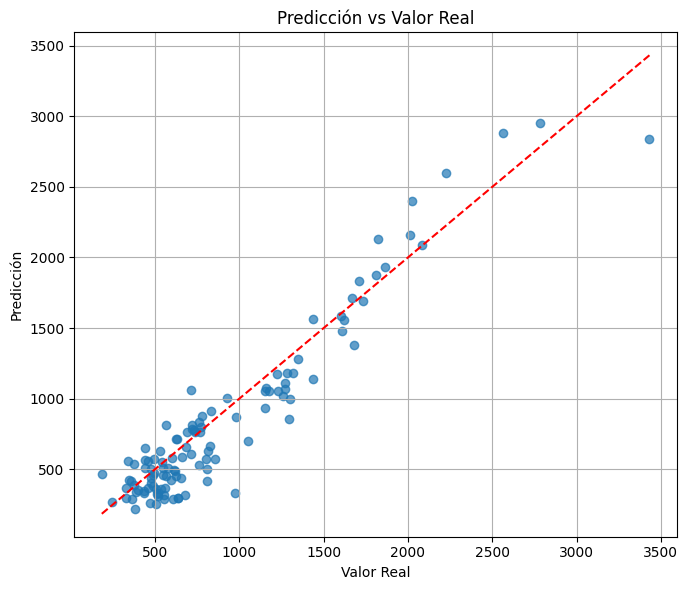

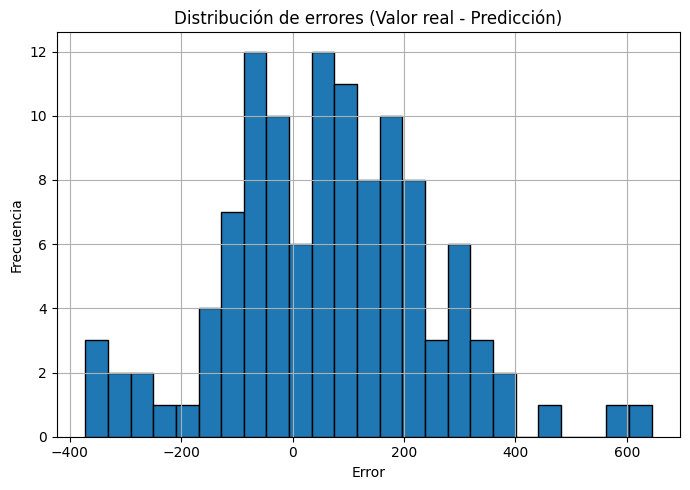

In [1]:
# ----------------------------------------
# 1. CARGA Y PREPROCESAMIENTO
# ----------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar la base de datos.
df = pd.read_csv("Breast_Cancer_Database.csv")

# Eliminar columnas irrelevantes.
# diagnosis se elimina porque no se busca clasificar tumores, sino predecir un valor continuo (regresión).
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
if 'diagnosis' in df.columns:
    df.drop(columns=['diagnosis'], inplace=True)

# Separar variables predictoras(X) y variable objetivo(area_worst).
target = 'area_worst'
y = df[target]
X = df.drop(columns=[target])

# Escalado (normalización) de las variables predictoras.
# Media 0 y desviación estándar 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar el conjunto de datos en entrenamiento y test.
# 80% entrenamiento y 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Conversión a float32 por compatibilidad con TensorFlow.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# ----------------------------------------
# 2. RED NEURONAL DE REGRESIÓN
# ----------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# Definición del modelo(red neuronal secuencial).
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Capa de entrada
    layers.Dense(64, activation='relu'),      # Capa oculta(64 neuronas)
    layers.Dropout(0.3),                      # Regularización para evitar el sobreajuste
    layers.Dense(32, activation='relu'),      # Capa oculta(32 neuronas)
    layers.Dense(1)                           # Capa de salida(1 neurona y sin activación)
])

# Compilación del modelo.
model.compile(
    optimizer='adam',
    loss='mse',           # Función de pérdida
    metrics=['mae', 'mse']
)

# Entrenamiento del modelo.
# EarlyStopping va a parar el entrenamiento si no hay mejora en 10 épocas consecutivas.
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación en el conjunto de test una vez entrenado.
results = model.evaluate(X_test, y_test, verbose=0)
print("\nResultados en test:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

# ----------------------------------------
# 3. VISUALIZACIÓN DE MÉTRICAS Y GRÁFICAS
# ----------------------------------------

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Gráficas de entrenamiento (MSE y MAE).
def plot_training(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Evolución del MSE")
    plt.xlabel("Épocas")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.title("Evolución del MAE")
        plt.xlabel("Épocas")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)

# Predicción sobre el conjunto de test.
y_pred = model.predict(X_test).flatten()

# Métricas de regresión.
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
tabla = plt.table(cellText=[[f"{mae:.4f}", f"{mse:.4f}", f"{rmse:.4f}", f"{r2:.4f}"]],
                  colLabels=["MAE", "MSE", "RMSE", "$R^2$"],
                  cellLoc='center', loc='center')

# Visualización de las métricas en una tabla.
tabla.scale(1, 2)
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
plt.title("Métricas de Regresión", fontsize=14)
plt.show()

# Gráfico de dispersión: Valor Real vs Predicción.
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograma de errores.
# Una forma simétrica y centrada en 0 sugiere buen ajuste.
errores = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.hist(errores, bins=25, edgecolor='black')
plt.title("Distribución de errores (Valor real - Predicción)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()
